In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')


import sys
sys.path.insert(0, "..")
from src.data import make_dataset
from pathlib import Path
import gin

datadir = Path("../data/raw/roomtemp")
data = make_dataset.get_roomtemp(datadir=datadir)
data = data.rename({'DAYTON_MW': 'temp', 'Datetime1': 'hour'}, axis=1)
data=data.drop(data.columns[[0, 3]], axis=1)
data.head()




2022-12-14 14:28:33.995 | INFO     | src.data.make_dataset:get_roomtemp:28 - Found ../data/raw/roomtemp/MLTempDataset.csv, load from disk


,hour,temp
0,0,20.867
1,1,21.000
2,2,20.867
3,3,20.650
4,4,20.400


In [13]:
import torch
series = data['temp']
tensordata = torch.from_numpy(series.to_numpy()).type(torch.float32)
tensordata

tensor([20.8670, 21.0000, 20.8670,  ..., 26.4500, 25.9000, 25.5670])

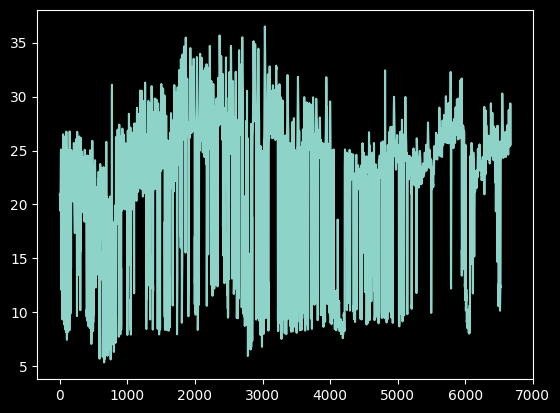

In [14]:
plt.plot(tensordata);

In [16]:
tensordata.__len__()

6676

In [19]:
# Train test split
split = 5000
train = tensordata[:split]

norm = max(train)
test = tensordata[split:]

train = train / norm
test = test/ norm


tensor([0.6671, 0.6762, 0.6816,  ..., 0.7247, 0.7096, 0.7005])

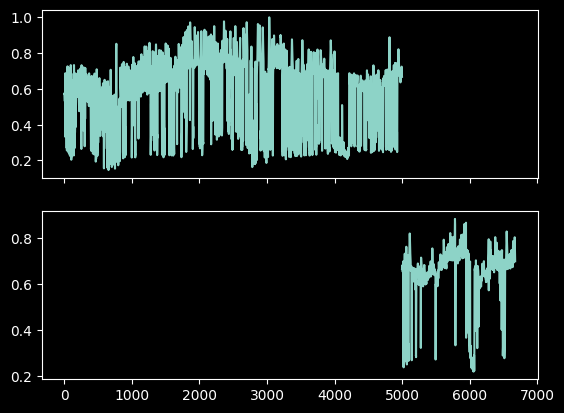

In [22]:
# reduce steps back to hours
idx0 = torch.arange(0, len(train))
idx1 = torch.arange(0, len(test)) + idx0.max()
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(idx0, train)
axs[1].plot(idx1,test)

In [34]:
from src.data import data_tools

window_size = 28 # this is just a wild guess. A bit over 24 hours
idx = data_tools.window(train, window_size)
trainset = train[idx]
idx = data_tools.window(test, window_size)
testset = test[idx]
trainset.shape, testset.shape

(torch.Size([4973, 28]), torch.Size([1649, 28]))

In [35]:
from torch.utils.data import DataLoader
trainset = trainset[...,None]
testset = testset[..., None]
trainset.shape, testset.shape

(torch.Size([4973, 28, 1]), torch.Size([1649, 28, 1]))

In [25]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, data, horizon):
        self.data = data
        self.size = len(data)
        self.horizon = horizon
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        # get a single item
        item = self.data[idx]
        # slice off the horizon
        x = item[:-self.horizon,:]
        y = item[-self.horizon:,:].squeeze(-1) # squeeze will remove the last dimension if possible.
        return x, y

In [37]:
horizon = 3
traindataset = CustomDataset(trainset, horizon=horizon)
testdataset = CustomDataset(testset, horizon=horizon)

trainloader = DataLoader(traindataset, batch_size=32, shuffle=True)
testloader = DataLoader(testdataset, batch_size=32, shuffle=True)

In [46]:
x, y = next(iter(trainloader))
x.shape, y.shape # here we see the squeeze in action

(torch.Size([32, 25, 1]), torch.Size([32, 3]))

In [47]:
from typing import Tuple
Tensor = torch.Tensor

def naivepredict(x: Tensor, horizon: int) -> Tuple[Tensor, Tensor]:
    assert horizon > 0
    yhat = x[...,-horizon:, :].squeeze(-1)
    return yhat


yhat = naivepredict(x, horizon) #this should be the same horizon you used to create the dataset
yhat.shape


def mae(y: Tensor, yhat: Tensor) -> Tensor:
    return torch.mean(torch.abs(y-yhat))


mae(y, yhat)

tensor(0.1022)

In [48]:
def naivenorm(dataloader: DataLoader, horizon: int):
    elist = []
    for x, y in dataloader:
        yhat = naivepredict(x, horizon)
        e = mae(y, yhat)
        elist.append(e)
    return torch.mean(torch.tensor(elist))
naivenorm(trainloader, 1)

tensor(0.0706)

In [49]:
Tensor = torch.Tensor
class MASE:
    def __init__(self, dataloader: DataLoader, horizon: int):
        self.scale = self.naivenorm(dataloader, horizon)
    
    def __repr__(self) -> str:
        # __repr__ is what is returned if you print the class to the screen 
        return f"MASE(scale={self.scale:.3f})"

    def naivenorm(self, dataloader: DataLoader, horizon: int):
        elist = []
        for x, y in dataloader:
            yhat = self.naivepredict(x, horizon)
            e = self.mae(y, yhat)
            elist.append(e)
        return torch.mean(torch.tensor(elist))
    
    def naivepredict(self, x: Tensor, horizon: int) -> Tuple[Tensor, Tensor]:
        assert horizon > 0
        yhat = x[...,-horizon:, :].squeeze(-1)
        return yhat

    def mae(self, y: Tensor, yhat: Tensor) -> Tensor:
        return torch.mean(torch.abs(y-yhat))
    
    def __call__(self, y: Tensor, yhat: Tensor) -> Tensor:
        # __call__ lets us call the class as a function
        return self.mae(y, yhat) / self.scale

In [51]:
mase = MASE(trainloader, horizon)
mase # __repr__ in action

MASE(scale=0.097)

In [54]:
from src.models import rnn_models, metrics
observations = window_size - horizon
model = rnn_models.BaseModel(observations=observations, horizon=horizon)
x, y = next(iter(trainloader))
x.shape, y.shape

(torch.Size([32, 25, 1]), torch.Size([32, 3]))

In [55]:
yhat = model(x)
yhat.shape

torch.Size([32, 3])

In [56]:
mase = metrics.MASE(trainloader, horizon)
mase(y, yhat)

KeyboardInterrupt: 